# Load Data

In [1]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir, read_unlabeled_data
from utils import TAG2IDX, IDX2TAG, DATA_DIR, POS_FINE_DIR, UNLABELED_DIR
from utils import MODEL_DIR, INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR
# from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, UnlabeledDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train_one_epoch, eval

from analysis import save_sns_fig, analysis_output, make_plot_metric

from create_pseudo_data import gen_pseudo_data_by_unlabel

import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)

import time


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [3]:
def run_online_fixed(domain, top_percent, lr=0.000001, max_loop=20):

  print("=========================================================")
  print("Create directories")
  (sub_model_dir, sub_metrics_dir, sub_result_dir, 
   sub_int_res_dir) = create_sub_dir(domain, method_name="Online_fixed_self_learning")

  print("=========================================================")
  print("Load data")
  time1 = time.time()

  ul_domain_file = os.path.join(UNLABELED_DIR, f"gweb-{domain}.unlabeled.txt")

  domain_dir = os.path.join(POS_FINE_DIR, f"{domain}")
  domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
  domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

  domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
  domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)

  domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
  domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

  dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)
  test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

  dev_iter = data.DataLoader(
      dataset=dev_dataset,
      batch_size=8,
      shuffle=True,
      num_workers=1,
      collate_fn=pad)
  test_iter = data.DataLoader(
      dataset=test_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=1,
      collate_fn=pad)
  
  time2 = time.time()
  print(" Running time:", time2 - time1)

  # =========================================================
  avg_domain_prec_lst = []
  avg_domain_rec_lst = []
  avg_domain_f1_lst = []
  avg_domain_acc_lst = []

  micro_domain_prec_lst = []
  micro_domain_rec_lst = []
  micro_domain_f1_lst = []
  micro_domain_acc_lst = []

  macro_domain_prec_lst = []
  macro_domain_rec_lst = []
  macro_domain_f1_lst = []
  macro_domain_acc_lst = []

  prob_lst = []

  print("=========================================================")
  print("Start Self-training")

  loop_i = 0

  domain_unlabeled_data = read_unlabeled_data(ul_domain_file, max_unlabeled=100_000)
  
  time3 = time.time()
  print(" Running time:", time3 - time2)

  print("  The number of unlabeled data", len(domain_unlabeled_data))

  topn = int(top_percent * len(domain_unlabeled_data))
  print("  The number of sentences in top n", topn)

  while len(domain_unlabeled_data) >= topn and loop_i <= max_loop:
    
    time4 = time.time()

    loop_i += 1
    print("\nLoop", loop_i)

    # =========================================================
    # Load model
    if loop_i == 1:
      model_name = [name for name in os.listdir(MODEL_DIR) if "base_model_" in name][0]
      model_file = os.path.join(MODEL_DIR, model_name)
    else:
      model_name = [name for name in os.listdir(sub_model_dir) if f"model-top{top_percent}-loop{loop_i-1}-lr{lr}" in name][0]
      model_file = os.path.join(sub_model_dir, model_name)
    
    print(model_file)

    model = Net(vocab_size=len(TAG2IDX))
    model.to(DEVICE)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_file))

    # =========================================================
    # Performance on test dataset

    output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}-lr{lr}.txt")
    
    (test_prec_avg, test_rec_avg, test_f1_avg, acc_avg, 
      test_prec_micro, test_rec_micro, test_f1_micro, test_acc_micro, 
      test_prec_macro, test_rec_macro, test_f1_macro, test_acc_macro) = eval(
        model, test_iter, save_output=True, output_file=output_res_file)
    
    time5 = time.time()
    print(" Running time:", time5 - time4)

    avg_domain_prec_lst.append(test_prec_avg.item())
    avg_domain_rec_lst.append(test_rec_avg.item())
    avg_domain_f1_lst.append(test_f1_avg.item())
    avg_domain_acc_lst.append(acc_avg.item())

    micro_domain_prec_lst.append(test_prec_micro.item())
    micro_domain_rec_lst.append(test_rec_micro.item())
    micro_domain_f1_lst.append(test_f1_micro.item())
    micro_domain_acc_lst.append(test_acc_micro.item())

    macro_domain_prec_lst.append(test_prec_macro.item())
    macro_domain_rec_lst.append(test_rec_macro.item())
    macro_domain_f1_lst.append(test_f1_macro.item())
    macro_domain_acc_lst.append(test_acc_macro.item())

    csv_file_name = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}-lr{lr}.csv")
    output_plot_name = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}-lr{lr}.png")

    _ = analysis_output(
        output_res_file, csvsave=True, pngsave=True, 
        csv_file_name=csv_file_name, output_plot_name=output_plot_name, 
        figtitle=f"{domain}-top{top_percent}-loop{loop_i} Test: Accuracy for each tag")

    print("=========================================================")
    print("Generate new train dataset")

    print("  The number of unlabeled data", len(domain_unlabeled_data))
    ul_domain_dataset = UnlabeledDataset(domain_unlabeled_data)
    unlabel_iter = data.DataLoader(
        dataset=ul_domain_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        collate_fn=pad
        )

    # Save analysis outputs for intermediate results
    output_int_res_file = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}-lr{lr}.txt")

    time6 = time.time()
    print(" Running time:", time6 - time5)

    (top_words, top_pseudo_tags, top_prob, 
     remain_words, remain_pseudo_tags, remain_prob)= gen_pseudo_data_by_unlabel(
          model, unlabel_iter, topn, save_output=True, output_file=output_int_res_file)
    
    time7 = time.time()
    print(" Running time:", time7 - time6)
    
    # Save top_prob
    prob_lst.append(top_prob)

    new_train_dataset = PosDataset(top_words, top_pseudo_tags)
    new_train_iter = data.DataLoader(
        dataset=new_train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        collate_fn=pad)
    
    # Only use remain data as new training dataset
    domain_unlabeled_data = remain_words
    
    time8 = time.time()
    print(" Running time:", time8 - time7)

    print("=========================================================")
    print("Self training for epochs")

    epoch_number = 0
    EPOCHS = 3

    best_vloss = 1_000_000.

    optimizer = optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(EPOCHS):
        print('  EPOCH {}:'.format(epoch_number + 1))

        model.train(True)
        avg_loss = train_one_epoch(model, new_train_iter, optimizer, loss_fn, epoch_number)

        model.train(False)

        running_vloss = 0.0
        for i, vbatch in enumerate(dev_iter):
          words, x, is_heads, tags, y, seqlens = vbatch

          logits, y, _ = model(x, y)
          logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
          y = y.view(-1)  # (N*T,)
          
          vloss = loss_fn(logits, y)
          running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('  LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = os.path.join(sub_model_dir, f'model-top{top_percent}-loop{loop_i}-lr{lr}')
            torch.save(model.state_dict(), model_path)

        epoch_number += 1
  
  time9 = time.time()
  print(" Running time:", time9 - time8)
  
  print("=========================================================")
  print("Save metrics and probability list")

  metrics_df = pd.DataFrame({
      "avg_domain_prec_lst": avg_domain_prec_lst,
      "avg_domain_rec_lst": avg_domain_rec_lst,
      "avg_domain_f1_lst": avg_domain_f1_lst,
      "avg_domain_acc_lst": avg_domain_acc_lst,

      "micro_domain_prec_lst": micro_domain_prec_lst,
      "micro_domain_rec_lst": micro_domain_rec_lst,
      "micro_domain_f1_lst": micro_domain_f1_lst,
      "micro_domain_acc_lst": micro_domain_acc_lst,

      "macro_domain_prec_lst": macro_domain_prec_lst,
      "macro_domain_rec_lst": macro_domain_rec_lst,
      "macro_domain_f1_lst": macro_domain_f1_lst,
      "macro_domain_acc_lst": macro_domain_acc_lst

  })

  metrics_df.to_csv(os.path.join(sub_metrics_dir, f"metrics_df-top{top_percent}-lr{lr}.csv"), index=False)
  make_plot_metric(metrics_df, sub_metrics_dir, name=f"top{top_percent}-lr{lr}")

  prob_df = pd.DataFrame({})
  for i in range(len(prob_lst)):
    prob_df[i+1] = prob_lst[i]
  prob_df.to_csv(os.path.join(sub_metrics_dir, f"prob_df-top{top_percent}-lr{lr}.csv"), index=False)
  
  time10 = time.time()
  print(" Running time:", time10 - time9)


In [4]:
top_percent_lst = [0.01] # 0.01, 0.02, 0.05, 0.1, 
lr_lst = [0.0000001] # 0.00001, 0.000001, 
DOMAIN_LST = ["answers"] # "emails", "newsgroups", "reviews", "weblogs"

In [5]:
# domain = "answers"
# top_percent = 0.2

In [6]:
# sub_metrics_dir = os.path.join(METRICS_DIR, "Online_fixed_self_learning", domain)
# metric_file = os.path.join(sub_metrics_dir, f"metrics_df-top{top_percent}.csv")
# metrics_df = pd.read_csv(metric_file)

# make_plot_metric(metrics_df, sub_metrics_dir, name=f"top{top_percent}")

wsj
- size: 30060, lr: 0.0001
answers
- dev size: 1745, lr: 0.0001
- unlaneled size: 27260

In [7]:
1745 * 0.0001 / 27260

6.401320616287602e-06


$$$ Run answers, top_percent 0.01, lr 1e-07
Create directories
Load data
The number of samples: 1745
The number of tags 49
The number of samples: 1744
The number of tags 50
after filter tag 1713
after filter tag 1723
 Running time: 0.17714166641235352
Start Self-training
Loaded... 27260 unlabeled instances
 Running time: 7.20922589302063
  The number of unlabeled data 27260
  The number of sentences in top n 272

Loop 1
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
 Running time: 15.864029169082642
Generate new train dataset
  The number of unlabeled data 27260
 Running time: 0.5977504253387451
 Running time: 112.6823136806488
 Running time: 0.009482383728027344
Self training for epochs
  EPOCH 1:
  LOSS train 0.0 valid 0.39445388317108154
  EPOCH 2:
  LOSS train 0.0 valid 0.38945841789245605
  EPOCH 3:
  LOSS train 0.0 valid 0.395428329706192

Loop 2
/content/drive/MyDrive/Colab Notebooks/Capstone/model/Online_fixed_self_learning/answers/model-top

/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Generate new train dataset
  The number of unlabeled data 21820
 Running time: 1.331366777420044
 Running time: 97.84265518188477
 Running time: 0.015404939651489258
Self training for epochs
  EPOCH 1:
  LOSS train 0.0 valid 0.4148940443992615
  EPOCH 2:
  LOSS train 0.0 valid 0.4076538681983948
  EPOCH 3:
  LOSS train 0.0 valid 0.4116707146167755
 Running time: 28.28070306777954
Save metrics and probability list
 Running time: 2.3082590103149414


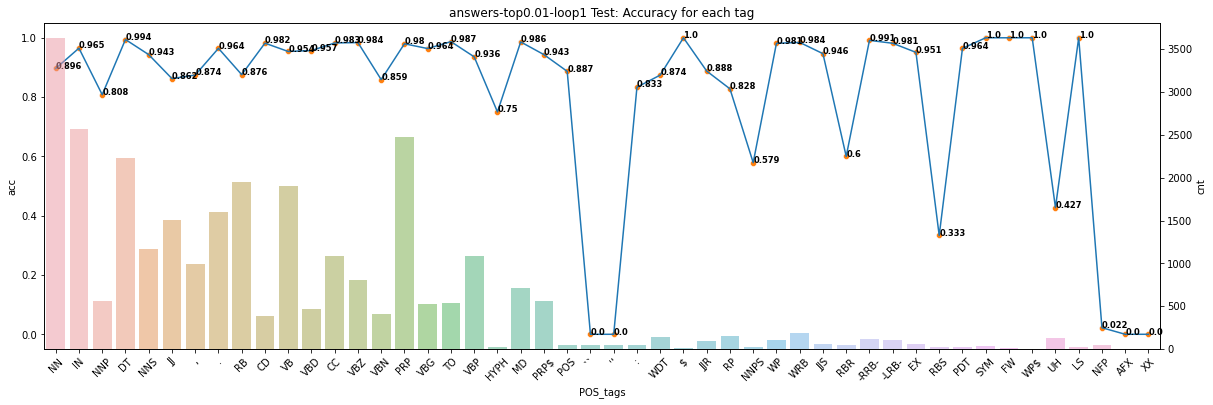

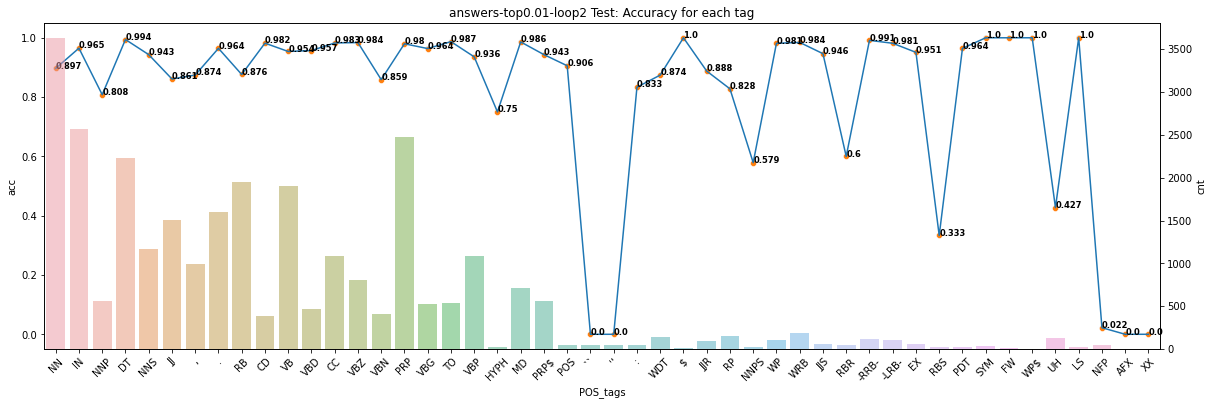

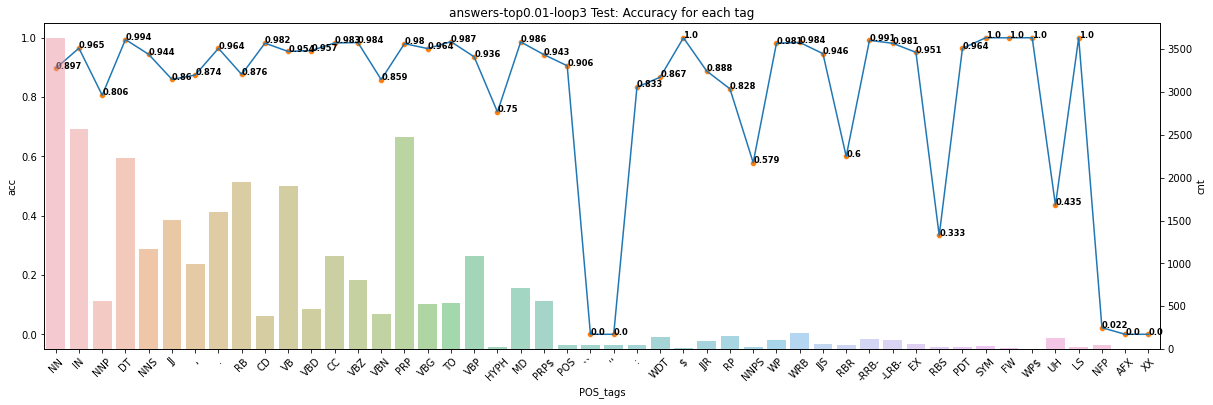

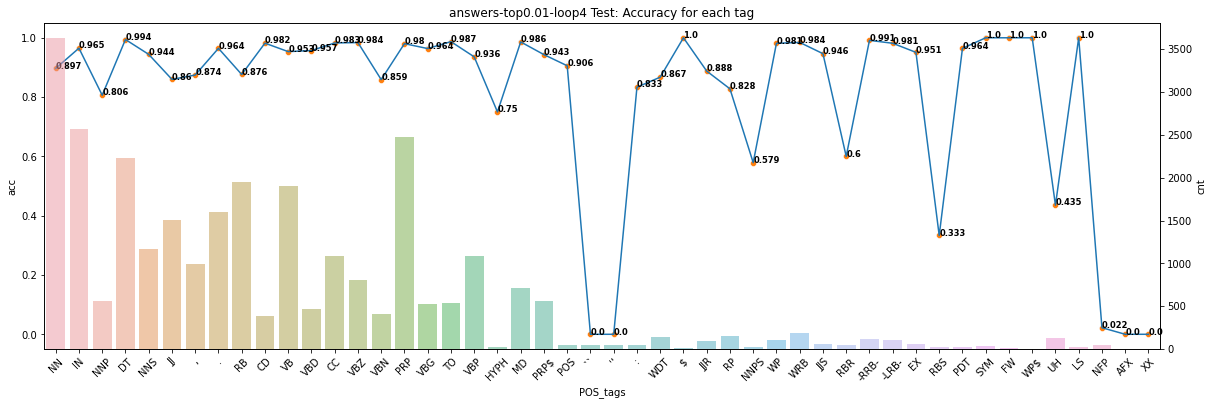

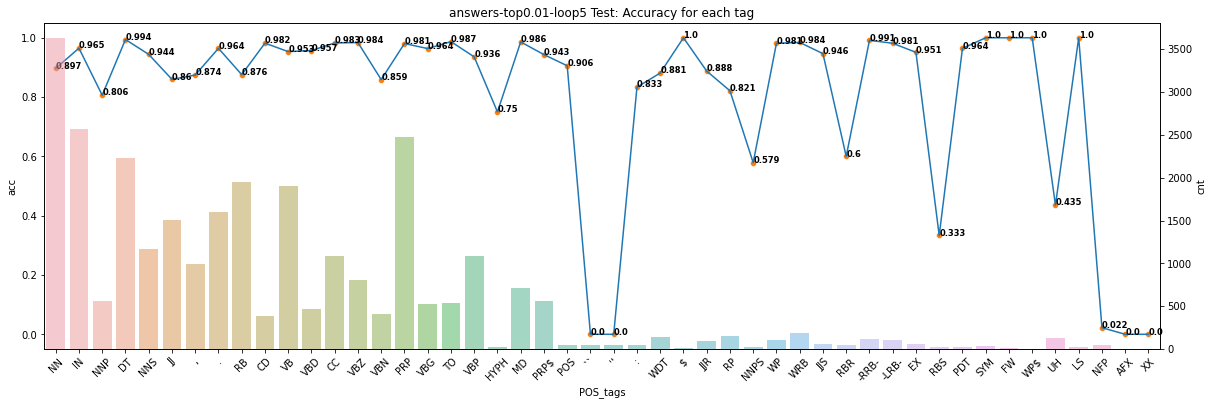

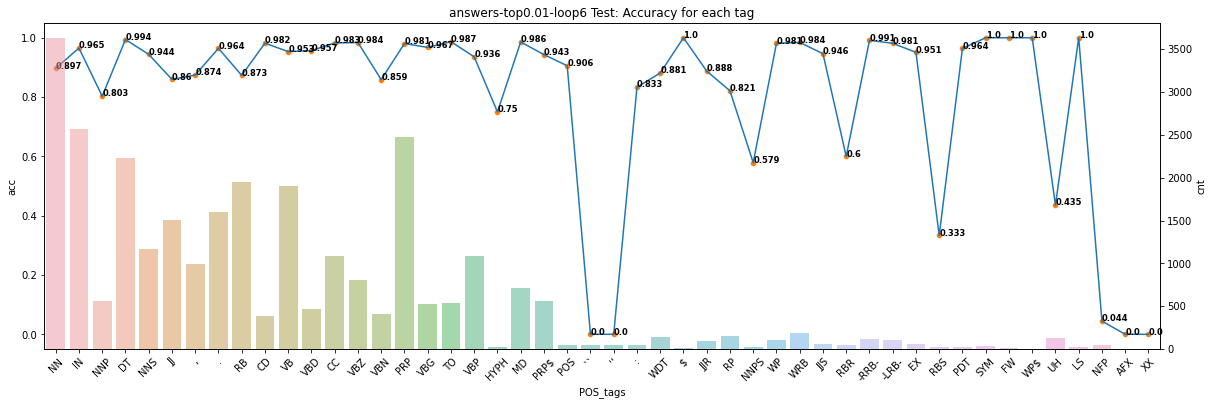

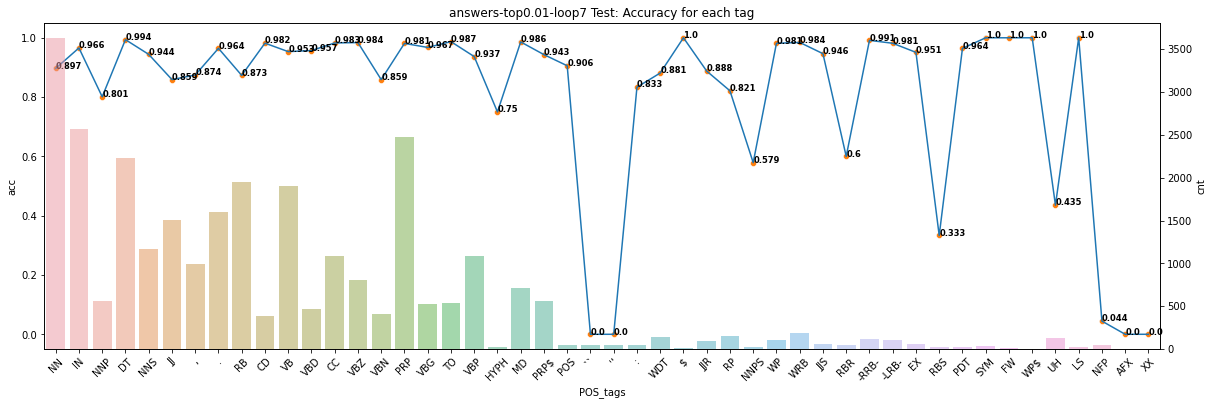

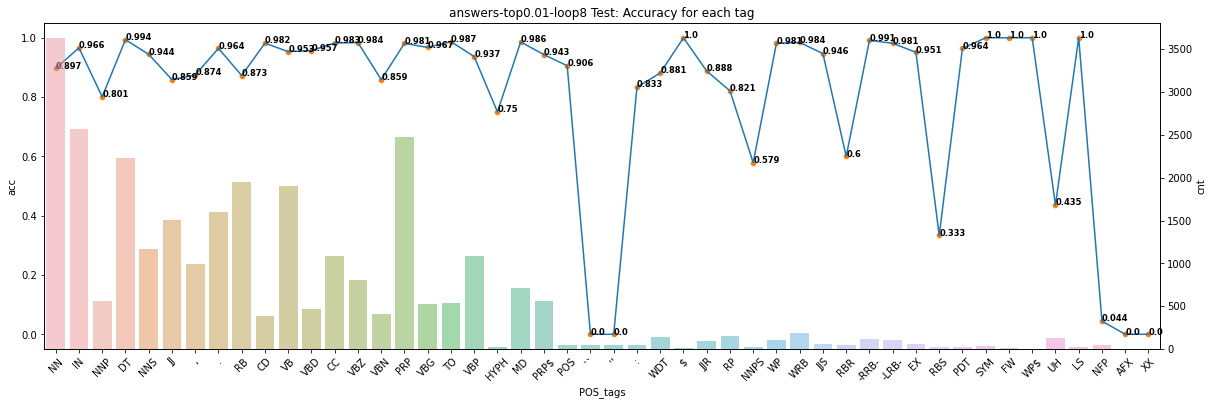

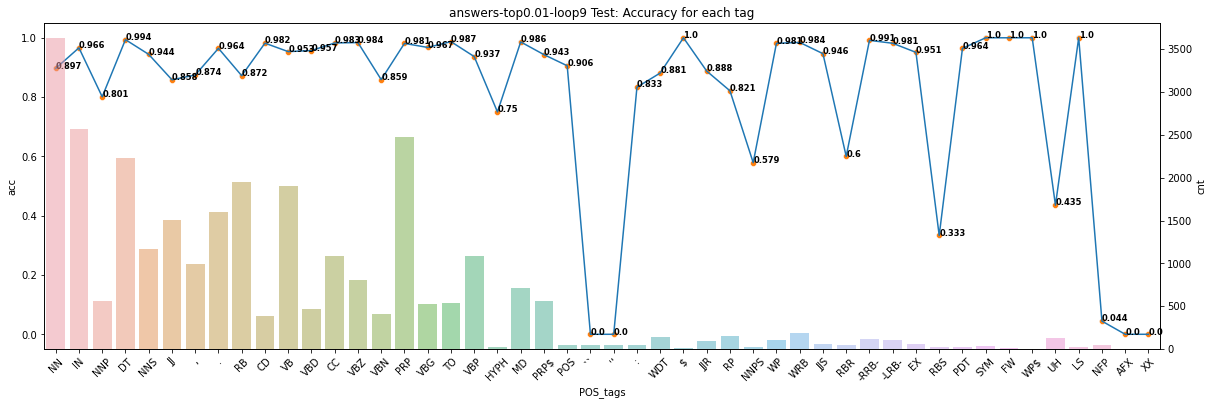

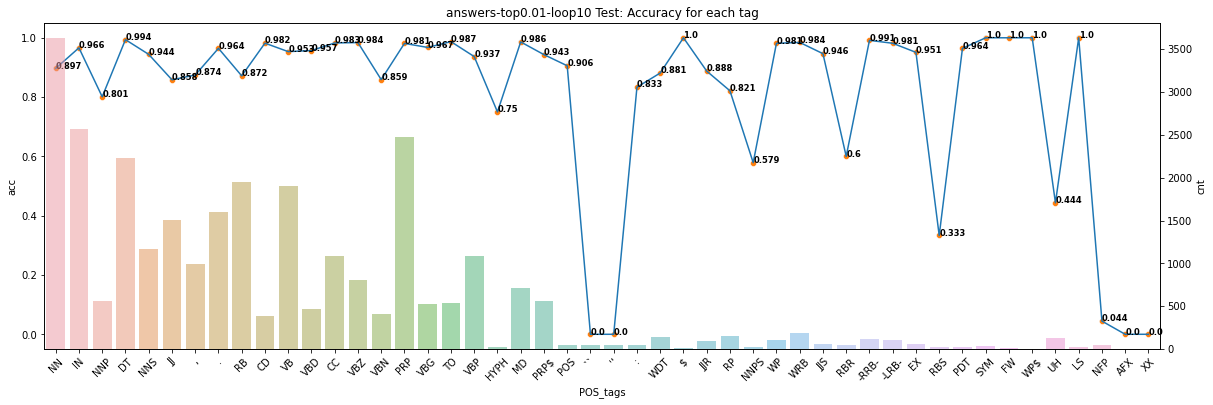

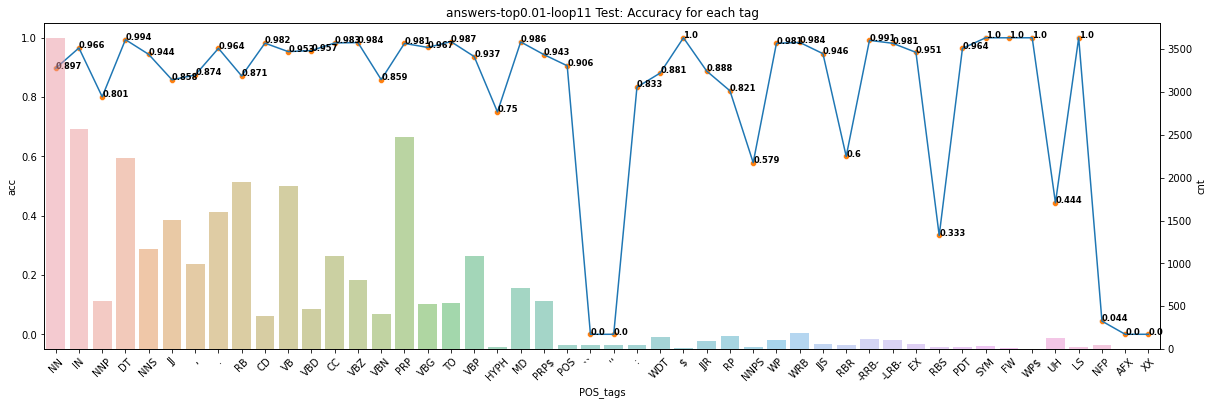

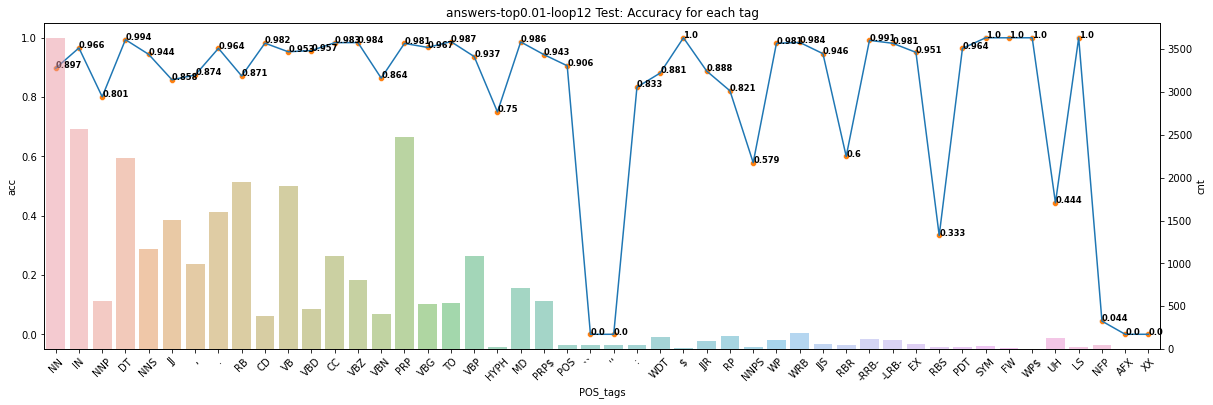

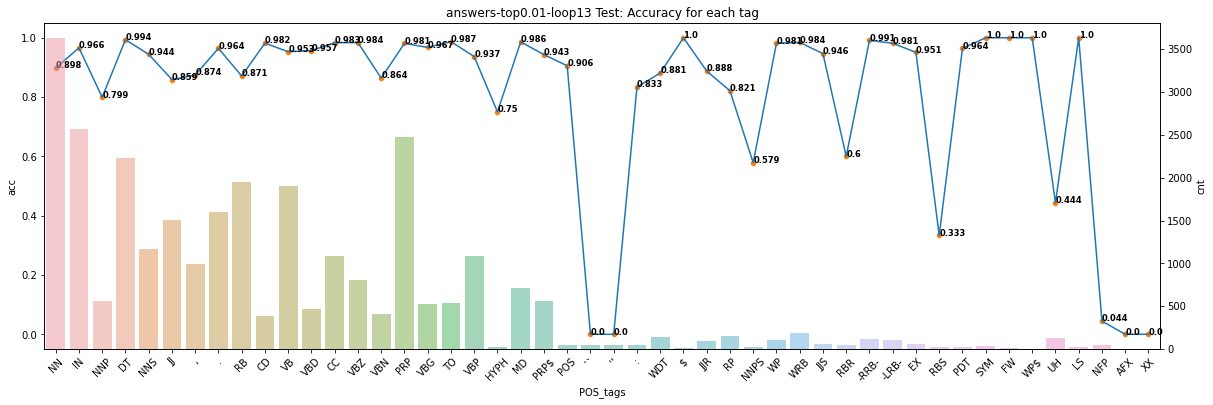

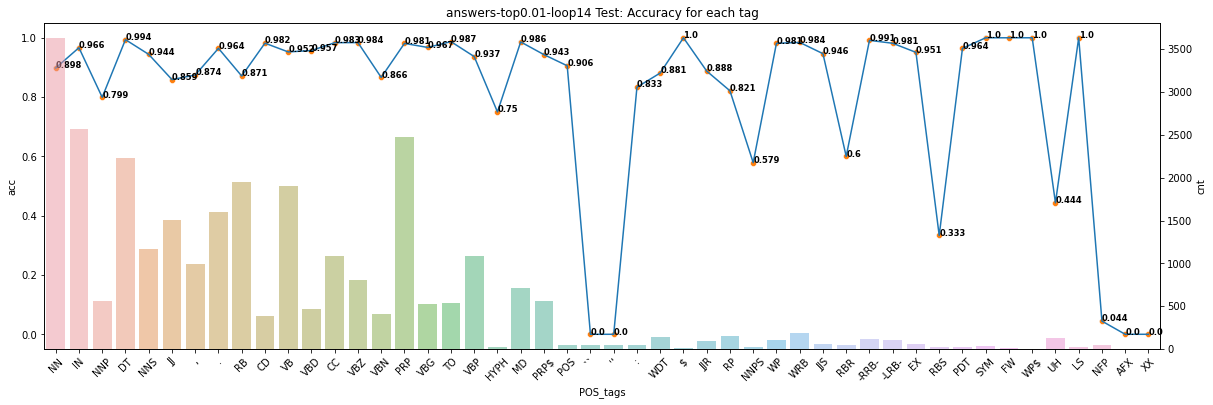

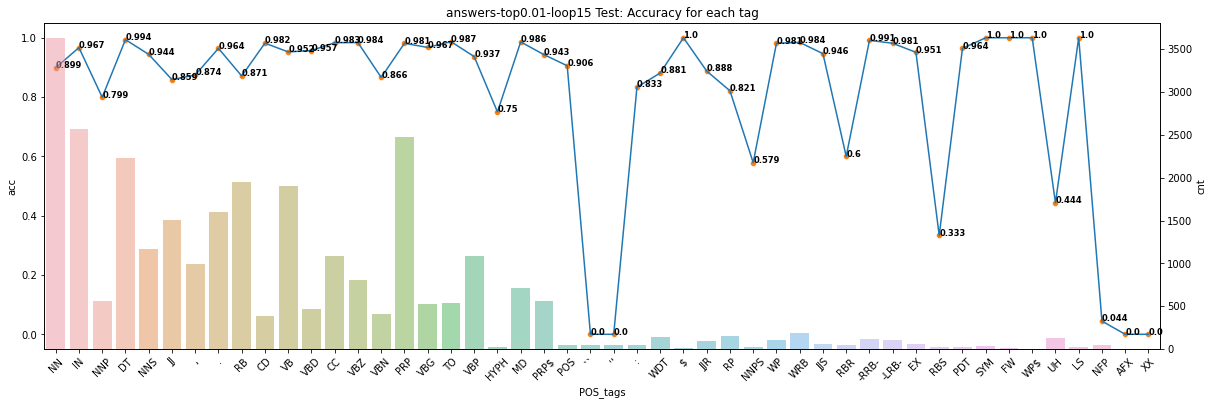

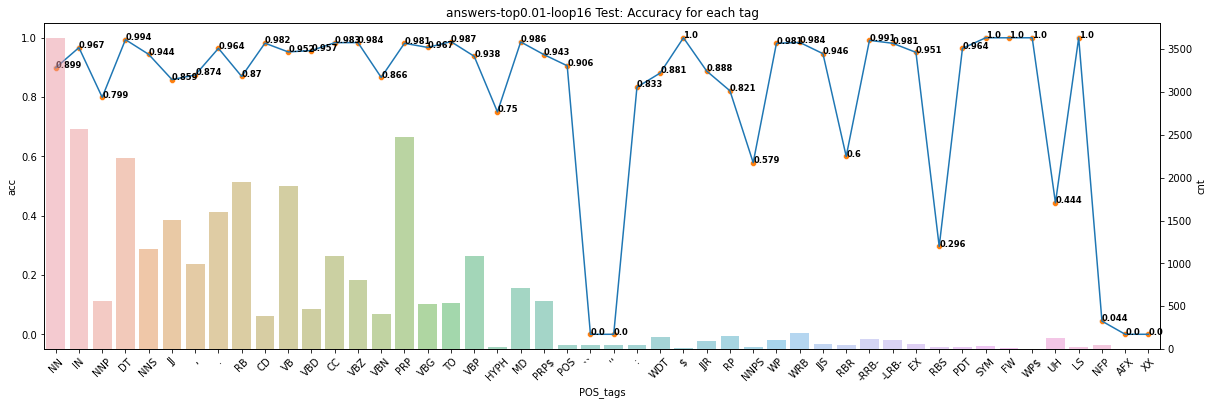

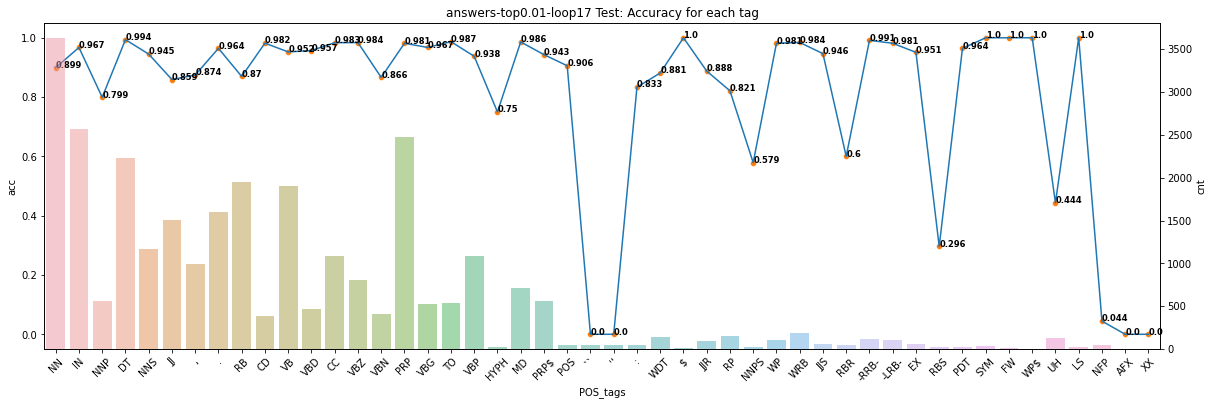

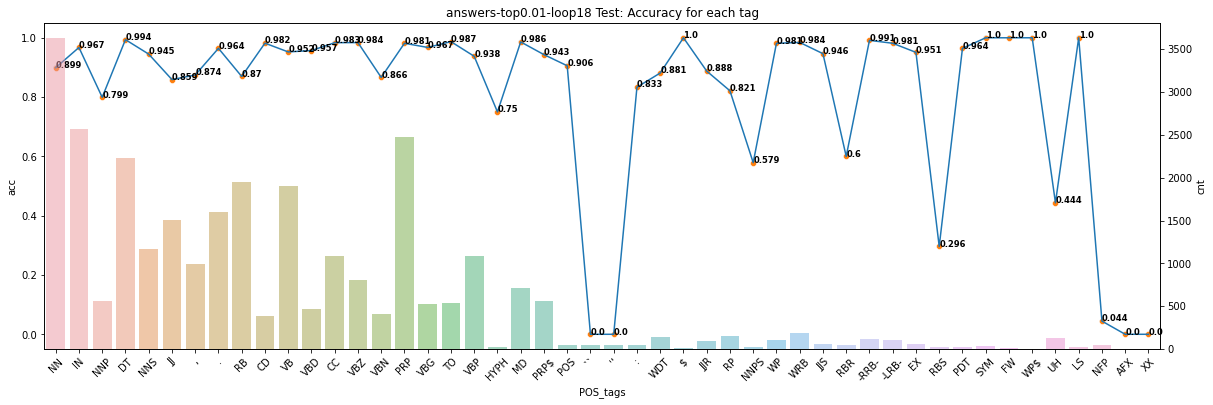

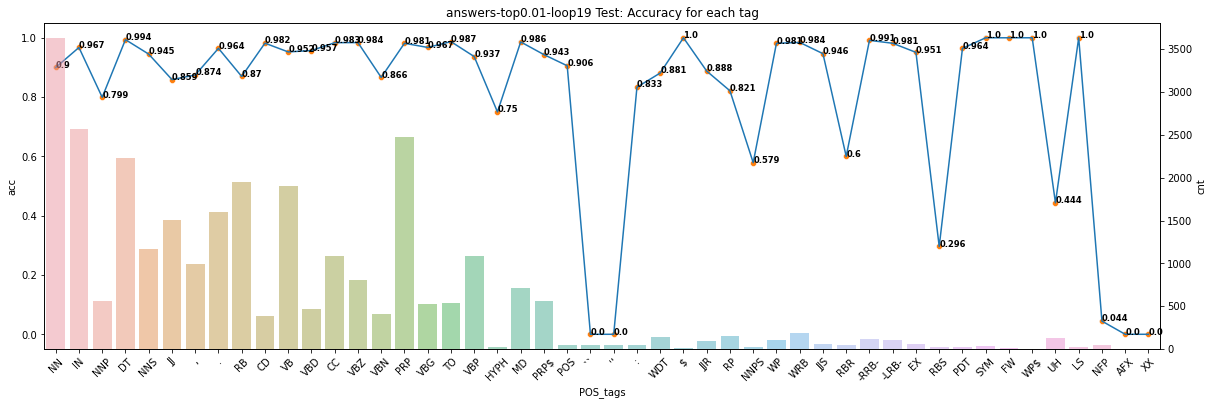

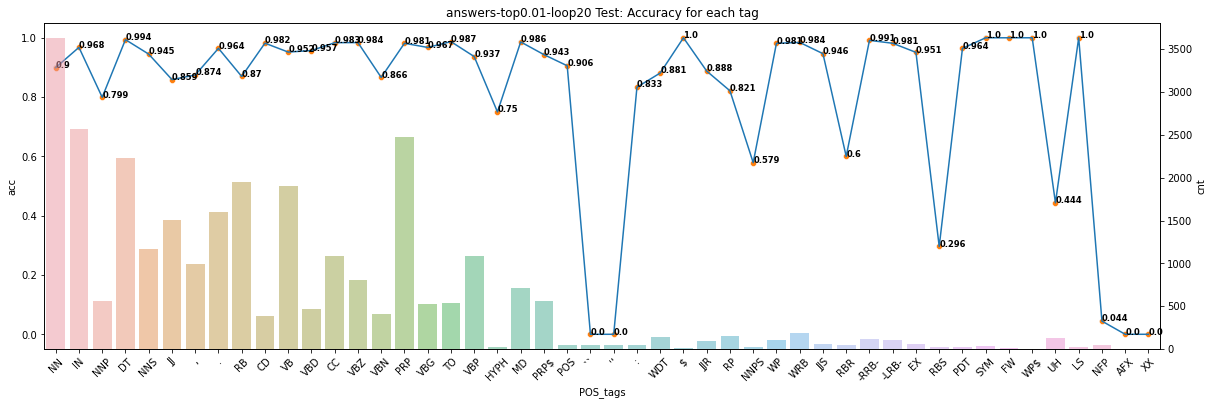

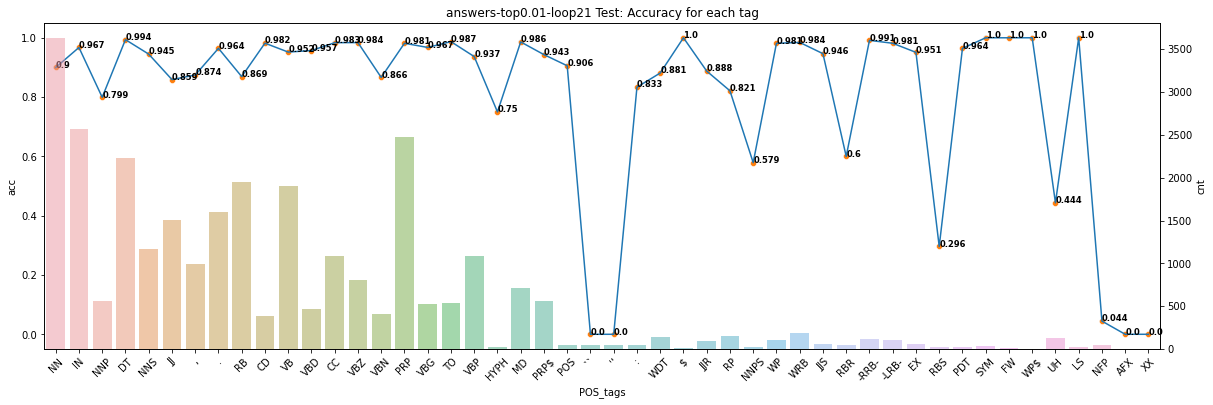

In [8]:
for top_percent in top_percent_lst:
  for domain in DOMAIN_LST:
    for lr in lr_lst:
      print(f"\n$$$ Run {domain}, top_percent {top_percent}, lr {lr}")
      # run_online_fixed(domain, top_percent, lr=lr)

      sub_metrics_dir = os.path.join(METRICS_DIR, "Online_fixed_self_learning", domain)
      if os.path.exists(os.path.join(sub_metrics_dir, f"metrics_df-top{top_percent}-lr{lr}.csv")):
        print("Already run")
      else:
        run_online_fixed(domain, top_percent, lr=lr)
      
      break
    break
  break